In [1]:
import torch.utils.data as utils
import torch.nn.functional as F
import torch
import torch.nn as nn
from torch.autograd import Variable
from torch.nn.parameter import Parameter
import numpy as np
import pandas as pd
import math
import time
from Modules import FilterLinear

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline  

In [3]:
print(torch.__version__)

2.2.2


In [4]:
def PrepareDataset(speed_matrix, BATCH_SIZE = 40, seq_len = 10, pred_len = 1, train_propotion = 0.7, valid_propotion = 0.2):
    """ Prepare training and testing datasets and dataloaders.
    
    Convert speed/volume/occupancy matrix to training and testing dataset. 
    The vertical axis of speed_matrix is the time axis and the horizontal axis 
    is the spatial axis.
    
    Args:
        speed_matrix: a Matrix containing spatial-temporal speed data for a network
        seq_len: length of input sequence
        pred_len: length of predicted sequence
    Returns:
        Training dataloader
        Testing dataloader
    """
    time_len = speed_matrix.shape[0]
    
    max_speed = speed_matrix.max().max()
    speed_matrix =  speed_matrix / max_speed
    
    speed_sequences, speed_labels = [], []
    for i in range(time_len - seq_len - pred_len):
        speed_sequences.append(speed_matrix.iloc[i:i+seq_len].values)
        speed_labels.append(speed_matrix.iloc[i+seq_len:i+seq_len+pred_len].values)
    speed_sequences, speed_labels = np.asarray(speed_sequences), np.asarray(speed_labels)
    
    # shuffle and split the dataset to training and testing datasets
    sample_size = speed_sequences.shape[0]
    index = np.arange(sample_size, dtype = int)
    np.random.shuffle(index)
    
    train_index = int(np.floor(sample_size * train_propotion))
    valid_index = int(np.floor(sample_size * ( train_propotion + valid_propotion)))
    
    train_data, train_label = speed_sequences[:train_index], speed_labels[:train_index]
    valid_data, valid_label = speed_sequences[train_index:valid_index], speed_labels[train_index:valid_index]
    test_data, test_label = speed_sequences[valid_index:], speed_labels[valid_index:]
    
    train_data, train_label = torch.Tensor(train_data), torch.Tensor(train_label)
    valid_data, valid_label = torch.Tensor(valid_data), torch.Tensor(valid_label)
    test_data, test_label = torch.Tensor(test_data), torch.Tensor(test_label)
    
    train_dataset = utils.TensorDataset(train_data, train_label)
    valid_dataset = utils.TensorDataset(valid_data, valid_label)
    test_dataset = utils.TensorDataset(test_data, test_label)
    
    train_dataloader = utils.DataLoader(train_dataset, batch_size = BATCH_SIZE, shuffle=True, drop_last = True)
    valid_dataloader = utils.DataLoader(valid_dataset, batch_size = BATCH_SIZE, shuffle=True, drop_last = True)
    test_dataloader = utils.DataLoader(test_dataset, batch_size = BATCH_SIZE, shuffle=True, drop_last = True)
    
    return train_dataloader, valid_dataloader, test_dataloader, max_speed

In [5]:
if __name__ == "__main__":
#     data = 'inrix'
    data = 'loop'
    directory = '../../Data_Warehouse/Data_network_traffic/'
    if data == 'inrix':
        speed_matrix =  pd.read_pickle( directory + 'inrix_seattle_speed_matrix_2012')
        A = np.load(directory + 'INRIX_Seattle_2012_A.npy')
        FFR_5min = np.load(directory + 'INRIX_Seattle_2012_reachability_free_flow_5min.npy')
        FFR_10min = np.load(directory + 'INRIX_Seattle_2012_reachability_free_flow_10min.npy')
        FFR_15min = np.load(directory + 'INRIX_Seattle_2012_reachability_free_flow_15min.npy')
        FFR_20min = np.load(directory + 'INRIX_Seattle_2012_reachability_free_flow_20min.npy')
        FFR_25min = np.load(directory + 'INRIX_Seattle_2012_reachability_free_flow_25min.npy')
        FFR = [FFR_5min, FFR_10min, FFR_15min, FFR_20min, FFR_25min]
    elif data == 'loop':
        speed_matrix =  pd.read_pickle( directory + 'speed_matrix_2015')
        A = np.load( directory + 'Loop_Seattle_2015_A.npy')
        FFR_5min = np.load( directory + 'Loop_Seattle_2015_reachability_free_flow_5min.npy')
        FFR_10min = np.load( directory + 'Loop_Seattle_2015_reachability_free_flow_10min.npy')
        FFR_15min = np.load( directory + 'Loop_Seattle_2015_reachability_free_flow_15min.npy')
        FFR_20min = np.load( directory + 'Loop_Seattle_2015_reachability_free_flow_20min.npy')
        FFR_25min = np.load( directory + 'Loop_Seattle_2015_reachability_free_flow_25min.npy')
        FFR = [FFR_5min, FFR_10min, FFR_15min, FFR_20min, FFR_25min]

In [6]:
train_dataloader, valid_dataloader, test_dataloader, max_speed = PrepareDataset(speed_matrix)

In [7]:
inputs, labels = next(iter(train_dataloader))
[batch_size, step_size, fea_size] = inputs.size()
input_dim = fea_size
hidden_dim = fea_size
output_dim = fea_size

In [8]:
def TrainModel(model, train_dataloader, valid_dataloader, learning_rate = 1e-5, num_epochs = 300, patience = 10, min_delta = 0.00001):
    
    inputs, labels = next(iter(train_dataloader))
    [batch_size, step_size, fea_size] = inputs.size()
    input_dim = fea_size
    hidden_dim = fea_size
    output_dim = fea_size
    
    model.cuda()
    
    loss_MSE = torch.nn.MSELoss()
    loss_L1 = torch.nn.L1Loss()

    learning_rate = 1e-5
    optimizer = torch.optim.RMSprop(model.parameters(), lr = learning_rate)
    
    use_gpu = torch.cuda.is_available()
    
    interval = 100
    losses_train = []
    losses_valid = []
    losses_epochs_train = []
    losses_epochs_valid = []
    
    cur_time = time.time()
    pre_time = time.time()
    
    # Variables for Early Stopping
    is_best_model = 0
    patient_epoch = 0
    
    for epoch in range(num_epochs):
#         print('Epoch {}/{}'.format(epoch, num_epochs - 1))
#         print('-' * 10)
        
        trained_number = 0
        
        valid_dataloader_iter = iter(valid_dataloader)
        
        losses_epoch_train = []
        losses_epoch_valid = []

        for data in train_dataloader:
            inputs, labels = data

            if inputs.shape[0] != batch_size:
                continue

            if use_gpu:
                inputs, labels = Variable(inputs.cuda()), Variable(labels.cuda())
            else: 
                inputs, labels = Variable(inputs), Variable(labels)
                
            model.zero_grad()

            outputs = model(inputs)
            
            loss_train = loss_MSE(outputs, torch.squeeze(labels))
            
            losses_train.append(loss_train.data)
            losses_epoch_train.append(loss_train.data)
            
            optimizer.zero_grad()
            
            loss_train.backward()
            
            optimizer.step()
            
            # validation 
            try: 
                inputs_val, labels_val = next(valid_dataloader_iter)
            except StopIteration:
                valid_dataloader_iter = iter(valid_dataloader)
                inputs_val, labels_val = next(valid_dataloader_iter)
            
            if use_gpu:
                inputs_val, labels_val = Variable(inputs_val.cuda()), Variable(labels_val.cuda())
            else: 
                inputs_val, labels_val = Variable(inputs_val), Variable(labels_val)

            outputs_val= model(inputs_val)

            loss_valid = loss_MSE(outputs_val, torch.squeeze(labels_val))
            losses_valid.append(loss_valid.data)
            losses_epoch_valid.append(loss_valid.data)
            
            # output
            trained_number += 1
            
        avg_losses_epoch_train = sum(losses_epoch_train) / float(len(losses_epoch_train))
        avg_losses_epoch_valid = sum(losses_epoch_valid) / float(len(losses_epoch_valid))
        losses_epochs_train.append(avg_losses_epoch_train)
        losses_epochs_valid.append(avg_losses_epoch_valid)
        
        # Early Stopping
        if epoch == 0:
            is_best_model = 1
            best_model = model
            min_loss_epoch_valid = 10000.0
            if avg_losses_epoch_valid < min_loss_epoch_valid:
                min_loss_epoch_valid = avg_losses_epoch_valid
        else:
            if min_loss_epoch_valid - avg_losses_epoch_valid > min_delta:
                is_best_model = 1
                best_model = model
                min_loss_epoch_valid = avg_losses_epoch_valid 
                patient_epoch = 0
            else:
                is_best_model = 0
                patient_epoch += 1
                if patient_epoch >= patience:
                    print('Early Stopped at Epoch:', epoch)
                    break
        
        # Print training parameters
        cur_time = time.time()
        print('Epoch: {}, train_loss: {}, valid_loss: {}, time: {}, best model: {}'.format( \
                epoch, \
                np.around(avg_losses_epoch_train.cpu().numpy(), decimals=8),\
                np.around(avg_losses_epoch_valid.cpu().numpy(), decimals=8),\
                np.around([cur_time - pre_time] , decimals=2),\
                is_best_model) )
        pre_time = cur_time
    return best_model, [losses_train, losses_valid, losses_epochs_train, losses_epochs_valid]


In [9]:
def TestModel(model, test_dataloader, max_speed):
    
    inputs, labels = next(iter(test_dataloader))
    [batch_size, step_size, fea_size] = inputs.size()

    cur_time = time.time()
    pre_time = time.time()
    
    use_gpu = torch.cuda.is_available()
    
    loss_MSE = torch.nn.MSELoss()
    loss_L1 = torch.nn.MSELoss()
    
    tested_batch = 0
    
    losses_mse = []
    losses_l1 = [] 
    
    for data in test_dataloader:
        inputs, labels = data
        
        if inputs.shape[0] != batch_size:
            continue
    
        if use_gpu:
            inputs, labels = Variable(inputs.cuda()), Variable(labels.cuda())
        else: 
            inputs, labels = Variable(inputs), Variable(labels)

        # rnn.loop() 
        hidden = model.initHidden(batch_size)

        outputs = None
        outputs = model(inputs)
    
    
        loss_MSE = torch.nn.MSELoss()
        loss_L1 = torch.nn.L1Loss()
        loss_mse = loss_MSE(outputs, torch.squeeze(labels))
        loss_l1 = loss_L1(outputs, torch.squeeze(labels))
    
        losses_mse.append(loss_mse.cpu().data.numpy())
        losses_l1.append(loss_l1.cpu().data.numpy())
    
        tested_batch += 1
    
        if tested_batch % 1000 == 0:
            cur_time = time.time()
            print('Tested #: {}, loss_l1: {}, loss_mse: {}, time: {}'.format( \
                  tested_batch * batch_size, \
                  np.around([loss_l1.data[0]], decimals=8), \
                  np.around([loss_mse.data[0]], decimals=8), \
                  np.around([cur_time - pre_time], decimals=8) ) )
            pre_time = cur_time
    losses_l1 = np.array(losses_l1)
    losses_mse = np.array(losses_mse)
    mean_l1 = np.mean(losses_l1) * max_speed
    std_l1 = np.std(losses_l1) * max_speed
    
    print('Tested: L1_mean: {}, L1_std : {}'.format(mean_l1, std_l1))
    return [losses_l1, losses_mse, mean_l1, std_l1]

In [10]:
class LSTM(nn.Module):
    def __init__(self, input_size, cell_size, hidden_size, output_last = True):
        """
        cell_size is the size of cell_state.
        hidden_size is the size of hidden_state, or say the output_state of each step
        """
        super(LSTM, self).__init__()
        
        self.cell_size = cell_size
        self.hidden_size = hidden_size
        self.fl = nn.Linear(input_size + hidden_size, hidden_size)
        self.il = nn.Linear(input_size + hidden_size, hidden_size)
        self.ol = nn.Linear(input_size + hidden_size, hidden_size)
        self.Cl = nn.Linear(input_size + hidden_size, hidden_size)
        
        self.output_last = output_last
        
    def step(self, input, Hidden_State, Cell_State):
        combined = torch.cat((input, Hidden_State), 1)
        f = F.sigmoid(self.fl(combined))
        i = F.sigmoid(self.il(combined))
        o = F.sigmoid(self.ol(combined))
        C = F.tanh(self.Cl(combined))
        Cell_State = f * Cell_State + i * C
        Hidden_State = o * F.tanh(Cell_State)
        
        return Hidden_State, Cell_State
    
    def forward(self, inputs):
        batch_size = inputs.size(0)
        time_step = inputs.size(1)
        Hidden_State, Cell_State = self.initHidden(batch_size)
        
        if self.output_last:
            for i in range(time_step):
                Hidden_State, Cell_State = self.step(torch.squeeze(inputs[:,i:i+1,:]), Hidden_State, Cell_State)  
            return Hidden_State
        else:
            outputs = None
            for i in range(time_step):
                Hidden_State, Cell_State = self.step(torch.squeeze(inputs[:,i:i+1,:]), Hidden_State, Cell_State)  
                if outputs is None:
                    outputs = Hidden_State.unsqueeze(1)
                else:
                    outputs = torch.cat((outputs, Hidden_State.unsqueeze(1)), 1)
            return outputs
    
    def initHidden(self, batch_size):
        use_gpu = torch.cuda.is_available()
        if use_gpu:
            Hidden_State = Variable(torch.zeros(batch_size, self.hidden_size).cuda())
            Cell_State = Variable(torch.zeros(batch_size, self.hidden_size).cuda())
            return Hidden_State, Cell_State
        else:
            Hidden_State = Variable(torch.zeros(batch_size, self.hidden_size))
            Cell_State = Variable(torch.zeros(batch_size, self.hidden_size))
            return Hidden_State, Cell_State
        

In [11]:
class ConvLSTM(nn.Module):
    def __init__(self, input_size, cell_size, hidden_size, output_last = True):
        """
        cell_size is the size of cell_state.
        hidden_size is the size of hidden_state, or say the output_state of each step
        """
        super(ConvLSTM, self).__init__()
        
        self.cell_size = cell_size
        self.hidden_size = hidden_size
        self.fl = nn.Linear(input_size + hidden_size, hidden_size)
        self.il = nn.Linear(input_size + hidden_size, hidden_size)
        self.ol = nn.Linear(input_size + hidden_size, hidden_size)
        self.Cl = nn.Linear(input_size + hidden_size, hidden_size)
        
        self.conv = nn.Conv1d(1, hidden_size, hidden_size)
        
        self.output_last = output_last
        
    def step(self, input, Hidden_State, Cell_State):
        
        conv = self.conv(input)
        
        combined = torch.cat((conv, Hidden_State), 1)
        f = F.sigmoid(self.fl(combined))
        i = F.sigmoid(self.il(combined))
        o = F.sigmoid(self.ol(combined))
        C = F.tanh(self.Cl(combined))
        Cell_State = f * Cell_State + i * C
        Hidden_State = o * F.tanh(Cell_State)
        
        return Hidden_State, Cell_State
    
    def forward(self, inputs):
        batch_size = inputs.size(0)
        time_step = inputs.size(1)
        Hidden_State, Cell_State = self.initHidden(batch_size)
        
        if self.output_last:
            for i in range(time_step):
                Hidden_State, Cell_State = self.step(torch.squeeze(inputs[:,i:i+1,:]), Hidden_State, Cell_State)  
            return Hidden_State
        else:
            outputs = None
            for i in range(time_step):
                Hidden_State, Cell_State = self.step(torch.squeeze(inputs[:,i:i+1,:]), Hidden_State, Cell_State)  
                if outputs is None:
                    outputs = Hidden_State.unsqueeze(1)
                else:
                    outputs = torch.cat((outputs, Hidden_State.unsqueeze(1)), 1)
            return outputs
    
    def initHidden(self, batch_size):
        use_gpu = torch.cuda.is_available()
        if use_gpu:
            Hidden_State = Variable(torch.zeros(batch_size, self.hidden_size).cuda())
            Cell_State = Variable(torch.zeros(batch_size, self.hidden_size).cuda())
            return Hidden_State, Cell_State
        else:
            Hidden_State = Variable(torch.zeros(batch_size, self.hidden_size))
            Cell_State = Variable(torch.zeros(batch_size, self.hidden_size))
            return Hidden_State, Cell_State
        

In [12]:
class LocalizedSpectralGraphConvolution(nn.Module):
    def __init__(self, A, K):
        
        super(LocalizedSpectralGraphConvolution, self).__init__()
        
        
        self.K = K
        self.A = A.cuda()
        feature_size = A.shape[0]
        self.D = torch.diag(torch.sum(self.A, dim=0)).cuda()
        
        I = torch.eye(feature_size,feature_size).cuda()
        self.L = I - torch.inverse(torch.sqrt(self.D)).matmul(self.A).matmul(torch.inverse(torch.sqrt(self.D))) 
        
        L_temp = I
        for i in range(K):
            L_temp = torch.matmul(L_temp, self.L)
            if i == 0:
                self.L_tensor = torch.unsqueeze(L_temp, 2)
            else:
                self.L_tensor = torch.cat((self.L_tensor, torch.unsqueeze(L_temp, 2)), 2)
            
        self.L_tensor = Variable(self.L_tensor.cuda(), requires_grad=False)

        self.params = Parameter(torch.FloatTensor(K).cuda())
        
        stdv = 1. / math.sqrt(K)
        for i in range(K):
            self.params[i].data.uniform_(-stdv, stdv)

    def forward(self, input):
        x = input

        conv = x.matmul( torch.sum(self.params.expand_as(self.L_tensor) * self.L_tensor, 2) )

        return conv
        
        
class LocalizedSpectralGraphConvolutionalLSTM(nn.Module):
    
    def __init__(self, K, A, feature_size, Clamp_A=True, output_last = True):
        '''
        Args:
            K: K-hop graph
            A: adjacency matrix
            FFR: free-flow reachability matrix
            feature_size: the dimension of features
            Clamp_A: Boolean value, clamping all elements of A between 0. to 1.
        '''
        super(LocalizedSpectralGraphConvolutionalLSTM, self).__init__()
        self.feature_size = feature_size
        self.hidden_size = feature_size
        
        self.K = K
        self.A = A
        self.gconv = LocalizedSpectralGraphConvolution(A, K)
    
        hidden_size = self.feature_size
        input_size = self.feature_size + hidden_size

        self.fl = nn.Linear(input_size, hidden_size)
        self.il = nn.Linear(input_size, hidden_size)
        self.ol = nn.Linear(input_size, hidden_size)
        self.Cl = nn.Linear(input_size, hidden_size)
        
        self.output_last = output_last
        
    def step(self, input, Hidden_State, Cell_State):
        
#         conv_sample_start = time.time()  
        conv = F.relu(self.gconv(input))
#         conv_sample_end = time.time()  
#         print('conv_sample:', (conv_sample_end - conv_sample_start))
        combined = torch.cat((conv, Hidden_State), 1)
        f = F.sigmoid(self.fl(combined))
        i = F.sigmoid(self.il(combined))
        o = F.sigmoid(self.ol(combined))
        C = F.tanh(self.Cl(combined))
        Cell_State = f * Cell_State + i * C
        Hidden_State = o * F.tanh(Cell_State)
        
        return Hidden_State, Cell_State
    
    def Bi_torch(self, a):
        a[a < 0] = 0
        a[a > 0] = 1
        return a
    
    def forward(self, inputs):
        batch_size = inputs.size(0)
        time_step = inputs.size(1)
        Hidden_State, Cell_State = self.initHidden(batch_size)
        
        outputs = None
        
        for i in range(time_step):
            Hidden_State, Cell_State = self.step(torch.squeeze(inputs[:,i:i+1,:]), Hidden_State, Cell_State)  

            if outputs is None:
                outputs = Hidden_State.unsqueeze(1)
            else:
                outputs = torch.cat((outputs, Hidden_State.unsqueeze(1)), 1)
#         print(type(outputs))
        
        if self.output_last:
            return outputs[:,-1,:]
        else:
            return outputs
    
    def initHidden(self, batch_size):
        use_gpu = torch.cuda.is_available()
        if use_gpu:
            Hidden_State = Variable(torch.zeros(batch_size, self.hidden_size).cuda())
            Cell_State = Variable(torch.zeros(batch_size, self.hidden_size).cuda())
            return Hidden_State, Cell_State
        else:
            Hidden_State = Variable(torch.zeros(batch_size, self.hidden_size))
            Cell_State = Variable(torch.zeros(batch_size, self.hidden_size))
            return Hidden_State, Cell_State
    def reinitHidden(self, batch_size, Hidden_State_data, Cell_State_data):
        use_gpu = torch.cuda.is_available()
        if use_gpu:
            Hidden_State = Variable(Hidden_State_data.cuda(), requires_grad=True)
            Cell_State = Variable(Cell_State_data.cuda(), requires_grad=True)
            return Hidden_State, Cell_State
        else:
            Hidden_State = Variable(Hidden_State_data, requires_grad=True)
            Cell_State = Variable(Cell_State_data, requires_grad=True)
            return Hidden_State, Cell_State

In [13]:
class SpectralGraphConvolution(nn.Module):
    def __init__(self, A):
        
        super(SpectralGraphConvolution, self).__init__()
        
        feature_size = A.shape[0]
        
        self.A = A
        self.D = torch.diag(torch.sum(self.A, dim=0))
        self.L = self.D - A
        self.param = Parameter(torch.FloatTensor(feature_size).cuda())
        stdv = 1. / math.sqrt(feature_size)
        self.param.data.uniform_(-stdv, stdv)
        
        self.e, self.v = torch.linalg.eig(self.L)
        self.vt = torch.conj(torch.transpose(self.v, -2, -1))
        self.v = Variable(self.v.cuda(), requires_grad=False)
        self.vt = Variable(self.vt.cuda(), requires_grad=False)
    
    def forward(self, input):
        x = input
        conv_sample_start = time.time()  
        real_part = x.matmul(self.v.real.matmul(torch.diag(self.param)).matmul(self.vt.real))
        imag_part = x.matmul(self.v.imag.matmul(torch.diag(self.param)).matmul(self.vt.imag))
        conv = real_part - imag_part
        conv_sample_end = time.time()  
        print('conv_sample:', (conv_sample_end - conv_sample_start))
        return conv
        
class SpectralGraphConvolutionalLSTM(nn.Module):
    
    def __init__(self, K, A, feature_size, Clamp_A=True, output_last = True):
        '''
        Args:
            K: K-hop graph
            A: adjacency matrix
            FFR: free-flow reachability matrix
            feature_size: the dimension of features
            Clamp_A: Boolean value, clamping all elements of A between 0. to 1.
        '''
        super(SpectralGraphConvolutionalLSTM, self).__init__()
        self.feature_size = feature_size
        self.hidden_size = feature_size
        
        self.K = K
        self.A = A
        self.gconv = SpectralGraphConvolution(A)
    
        hidden_size = self.feature_size
        input_size = self.feature_size + hidden_size

        self.fl = nn.Linear(input_size, hidden_size)
        self.il = nn.Linear(input_size, hidden_size)
        self.ol = nn.Linear(input_size, hidden_size)
        self.Cl = nn.Linear(input_size, hidden_size)
        
        self.output_last = output_last
        
    def step(self, input, Hidden_State, Cell_State):
        conv_sample_start = time.time()  
        conv = self.gconv(input)
        conv_sample_end = time.time()  
        print('conv_sample:', (conv_sample_end - conv_sample_start))
        combined = torch.cat((conv, Hidden_State), 1)
        f = F.sigmoid(self.fl(combined))
        i = F.sigmoid(self.il(combined))
        o = F.sigmoid(self.ol(combined))
        C = F.tanh(self.Cl(combined))
        Cell_State = f * Cell_State + i * C
        Hidden_State = o * F.tanh(Cell_State)
        
        return Hidden_State, Cell_State
    
    def Bi_torch(self, a):
        a[a < 0] = 0
        a[a > 0] = 1
        return a
    
    def forward(self, inputs):
        batch_size = inputs.size(0)
        time_step = inputs.size(1)
        Hidden_State, Cell_State = self.initHidden(batch_size)
        
        outputs = None
        
        train_sample_start = time.time()  
        
        for i in range(time_step):
            Hidden_State, Cell_State = self.step(torch.squeeze(inputs[:,i:i+1,:]), Hidden_State, Cell_State)  

            if outputs is None:
                outputs = Hidden_State.unsqueeze(1)
            else:
                outputs = torch.cat((outputs, Hidden_State.unsqueeze(1)), 1)
        
        train_sample_end = time.time()
        print('train sample:' , (train_sample_end - train_sample_start))
        if self.output_last:
            return outputs[:,-1,:]
        else:
            return outputs
    
    def initHidden(self, batch_size):
        use_gpu = torch.cuda.is_available()
        if use_gpu:
            Hidden_State = Variable(torch.zeros(batch_size, self.hidden_size).cuda())
            Cell_State = Variable(torch.zeros(batch_size, self.hidden_size).cuda())
            return Hidden_State, Cell_State
        else:
            Hidden_State = Variable(torch.zeros(batch_size, self.hidden_size))
            Cell_State = Variable(torch.zeros(batch_size, self.hidden_size))
            return Hidden_State, Cell_State
    def reinitHidden(self, batch_size, Hidden_State_data, Cell_State_data):
        use_gpu = torch.cuda.is_available()
        if use_gpu:
            Hidden_State = Variable(Hidden_State_data.cuda(), requires_grad=True)
            Cell_State = Variable(Cell_State_data.cuda(), requires_grad=True)
            return Hidden_State, Cell_State
        else:
            Hidden_State = Variable(Hidden_State_data, requires_grad=True)
            Cell_State = Variable(Cell_State_data, requires_grad=True)
            return Hidden_State, Cell_State

In [14]:
class GraphConvolutionalLSTM(nn.Module):
    
    def __init__(self, K, A, FFR, feature_size, Clamp_A=True, output_last = True):
        '''
        Args:
            K: K-hop graph
            A: adjacency matrix
            FFR: free-flow reachability matrix
            feature_size: the dimension of features
            Clamp_A: Boolean value, clamping all elements of A between 0. to 1.
        '''
        super(GraphConvolutionalLSTM, self).__init__()
        self.feature_size = feature_size
        self.hidden_size = feature_size
        
        self.K = K
        
        self.A_list = [] # Adjacency Matrix List
        A = torch.FloatTensor(A)
        A_temp = torch.eye(feature_size,feature_size)
        for i in range(K):
            A_temp = torch.matmul(A_temp, torch.Tensor(A))
            if Clamp_A:
                # confine elements of A 
                A_temp = torch.clamp(A_temp, max = 1.) 
            self.A_list.append(torch.mul(A_temp, torch.Tensor(FFR)))
#             self.A_list.append(A_temp)
        
        # a length adjustable Module List for hosting all graph convolutions
        self.gc_list = nn.ModuleList([FilterLinear(feature_size, feature_size, self.A_list[i], bias=False) for i in range(K)])                  
        
        hidden_size = self.feature_size
        input_size = self.feature_size * K

        self.fl = nn.Linear(input_size + hidden_size, hidden_size)
        self.il = nn.Linear(input_size + hidden_size, hidden_size)
        self.ol = nn.Linear(input_size + hidden_size, hidden_size)
        self.Cl = nn.Linear(input_size + hidden_size, hidden_size)
        
        # initialize the neighbor weight for the cell state
        self.Neighbor_weight = Parameter(torch.FloatTensor(feature_size))
        stdv = 1. / math.sqrt(feature_size)
        self.Neighbor_weight.data.uniform_(-stdv, stdv)
        
        self.output_last = output_last
        
    def step(self, input, Hidden_State, Cell_State):
        
        x = input

        gc = self.gc_list[0](x)
        for i in range(1, self.K):
            gc = torch.cat((gc, self.gc_list[i](x)), 1)
            
        combined = torch.cat((gc, Hidden_State), 1)
        f = F.sigmoid(self.fl(combined))
        i = F.sigmoid(self.il(combined))
        o = F.sigmoid(self.ol(combined))
        C = F.tanh(self.Cl(combined))

        NC = torch.mul(Cell_State,  torch.mv(Variable(self.A_list[-1], requires_grad=False).cuda(), self.Neighbor_weight))
        Cell_State = f * NC + i * C
        Hidden_State = o * F.tanh(Cell_State)

        return Hidden_State, Cell_State, gc
    
    def Bi_torch(self, a):
        a[a < 0] = 0
        a[a > 0] = 1
        return a
    
    def forward(self, inputs):
        batch_size = inputs.size(0)
        time_step = inputs.size(1)
        Hidden_State, Cell_State = self.initHidden(batch_size)
        
        outputs = None
        
        for i in range(time_step):
            Hidden_State, Cell_State, gc = self.step(torch.squeeze(inputs[:,i:i+1,:]), Hidden_State, Cell_State)  

            if outputs is None:
                outputs = Hidden_State.unsqueeze(1)
            else:
                outputs = torch.cat((outputs, Hidden_State.unsqueeze(1)), 1)
        
        if self.output_last:
            return outputs[:,-1,:]
        else:
            return outputs
    
    def initHidden(self, batch_size):
        use_gpu = torch.cuda.is_available()
        if use_gpu:
            Hidden_State = Variable(torch.zeros(batch_size, self.hidden_size).cuda())
            Cell_State = Variable(torch.zeros(batch_size, self.hidden_size).cuda())
            return Hidden_State, Cell_State
        else:
            Hidden_State = Variable(torch.zeros(batch_size, self.hidden_size))
            Cell_State = Variable(torch.zeros(batch_size, self.hidden_size))
            return Hidden_State, Cell_State
    def reinitHidden(self, batch_size, Hidden_State_data, Cell_State_data):
        use_gpu = torch.cuda.is_available()
        if use_gpu:
            Hidden_State = Variable(Hidden_State_data.cuda(), requires_grad=True)
            Cell_State = Variable(Cell_State_data.cuda(), requires_grad=True)
            return Hidden_State, Cell_State
        else:
            Hidden_State = Variable(Hidden_State_data, requires_grad=True)
            Cell_State = Variable(Cell_State_data, requires_grad=True)
            return Hidden_State, Cell_State

In [15]:
lstm = LSTM(input_dim, hidden_dim, output_dim, output_last = True)
lstm, lstm_loss = TrainModel(lstm, train_dataloader, valid_dataloader, num_epochs = 1)
lstm_test = TestModel(lstm, test_dataloader, max_speed )

Epoch: 0, train_loss: 0.006963119842112064, valid_loss: 0.0071799298748373985, time: [17.55], best model: 1
Tested: L1_mean: 4.714443463070619, L1_std : 0.3873936721357717


In [16]:
K = 64
Clamp_A = False
lsgclstm = LocalizedSpectralGraphConvolutionalLSTM(K, torch.Tensor(A), A.shape[0], Clamp_A=Clamp_A, output_last = True)
lsgclstm, lsgclstm_loss = TrainModel(lsgclstm, train_dataloader, valid_dataloader, num_epochs = 1)
lsgclstm_test = TestModel(lsgclstm, test_dataloader, max_speed )

Epoch: 0, train_loss: 0.3602157235145569, valid_loss: 0.3619309067726135, time: [21.86], best model: 1
Tested: L1_mean: 79.56433098056912, L1_std : 0.8705524057156667


In [17]:
K = 3
back_length = 3
Clamp_A = False
sgclstm = SpectralGraphConvolutionalLSTM(K, torch.Tensor(A), A.shape[0], Clamp_A=Clamp_A, output_last = True)
sgclstm, sgclstm_loss = TrainModel(sgclstm, train_dataloader, valid_dataloader, num_epochs = 1)
sgclstm_test = TestModel(sgclstm, test_dataloader, max_speed )

conv_sample: 0.0
conv_sample: 0.0
conv_sample: 0.0
conv_sample: 0.0
conv_sample: 0.0
conv_sample: 0.0
conv_sample: 0.0
conv_sample: 0.0
conv_sample: 0.0
conv_sample: 0.0
conv_sample: 0.0
conv_sample: 0.0
conv_sample: 0.0
conv_sample: 0.0
conv_sample: 0.0009996891021728516
conv_sample: 0.0009996891021728516
conv_sample: 0.0
conv_sample: 0.0
conv_sample: 0.0
conv_sample: 0.0
train sample: 0.0039997100830078125
conv_sample: 0.0
conv_sample: 0.0
conv_sample: 0.0009920597076416016
conv_sample: 0.0009920597076416016
conv_sample: 0.0005040168762207031
conv_sample: 0.0005040168762207031
conv_sample: 0.0
conv_sample: 0.0
conv_sample: 0.0
conv_sample: 0.0
conv_sample: 0.0
conv_sample: 0.0
conv_sample: 0.0
conv_sample: 0.0
conv_sample: 0.0009999275207519531
conv_sample: 0.0009999275207519531
conv_sample: 0.0
conv_sample: 0.0
conv_sample: 0.0
conv_sample: 0.0
train sample: 0.004499912261962891
conv_sample: 0.0
conv_sample: 0.0
conv_sample: 0.0
conv_sample: 0.0
conv_sample: 0.0
conv_sample: 0.0
con

In [18]:
K = 3
back_length = 3
Clamp_A = False
gclstm = GraphConvolutionalLSTM(K, torch.Tensor(A), FFR[back_length], A.shape[0], Clamp_A=Clamp_A, output_last = True)
gclstm, gclstm_loss = TrainModel(gclstm, train_dataloader, valid_dataloader, num_epochs = 1)
gclstm_test = TestModel(gclstm, test_dataloader, max_speed )

Epoch: 0, train_loss: 0.003816179931163788, valid_loss: 0.0041324300691485405, time: [32.7], best model: 1
Tested: L1_mean: 4.1349796379814965, L1_std : 0.2944390542943439


In [26]:
#rnn_val_loss = np.asarray(rnn_loss[3])

print(lsgclstm_loss)
#print([tensor.item() for tensor, _ in lstm_loss])
lstm_val_loss = np.asarray(torch.stack(lstm_loss[0]).tolist())
hgclstm_val_loss = np.asarray(torch.stack(gclstm_loss[0]).tolist())
lsgclstm_val_loss = np.asarray(torch.stack(lsgclstm_loss[0]).tolist())
sgclstm_val_loss = np.asarray(torch.stack(sgclstm_loss[0]).tolist())

[[tensor(0.3723, device='cuda:0'), tensor(0.3764, device='cuda:0'), tensor(0.3636, device='cuda:0'), tensor(0.3548, device='cuda:0'), tensor(0.3639, device='cuda:0'), tensor(0.3619, device='cuda:0'), tensor(0.3719, device='cuda:0'), tensor(0.3648, device='cuda:0'), tensor(0.3684, device='cuda:0'), tensor(0.3670, device='cuda:0'), tensor(0.3676, device='cuda:0'), tensor(0.3714, device='cuda:0'), tensor(0.3660, device='cuda:0'), tensor(0.3679, device='cuda:0'), tensor(0.3662, device='cuda:0'), tensor(0.3675, device='cuda:0'), tensor(0.3694, device='cuda:0'), tensor(0.3650, device='cuda:0'), tensor(0.3649, device='cuda:0'), tensor(0.3670, device='cuda:0'), tensor(0.3653, device='cuda:0'), tensor(0.3690, device='cuda:0'), tensor(0.3658, device='cuda:0'), tensor(0.3591, device='cuda:0'), tensor(0.3649, device='cuda:0'), tensor(0.3598, device='cuda:0'), tensor(0.3663, device='cuda:0'), tensor(0.3666, device='cuda:0'), tensor(0.3684, device='cuda:0'), tensor(0.3605, device='cuda:0'), tensor(0

In [20]:
# lstm_val_loss = np.load('lstm_val_loss.npy')
# hgclstm_val_loss = np.load('hgclstm_val_loss.npy')
# lsgclstm_val_loss = np.load('lsgclstm_val_loss.npy')
# sgclstm_val_loss = np.load('sgclstm_val_loss.npy')

In [21]:
np.save('lstm_val_loss', lstm_val_loss)
np.save('hgclstm_val_loss', hgclstm_val_loss)
np.save('lsgclstm_val_loss', lsgclstm_val_loss)
np.save('sgclstm_val_loss', sgclstm_val_loss)

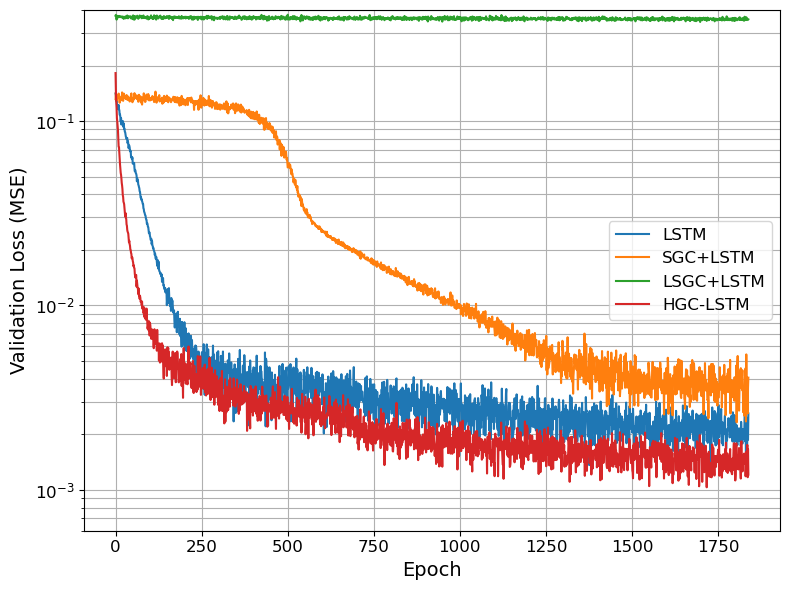

In [22]:
fig, ax = plt.subplots(figsize=(8, 6))
plt.plot(lstm_val_loss,  label = 'LSTM')
plt.plot(sgclstm_val_loss,  label = 'SGC+LSTM')
plt.plot(lsgclstm_val_loss,  label = 'LSGC+LSTM')
plt.plot(hgclstm_val_loss,  label = 'HGC-LSTM')
plt.ylim((6 * 0.0001, 0.4))
plt.xticks(fontsize = 12)
plt.yticks(fontsize = 12)
plt.yscale('log')
plt.ylabel('Validation Loss (MSE)', fontsize=14)
plt.xlabel('Epoch', fontsize=14)
plt.legend(fontsize=12)
plt.grid(True, which='both')
plt.tight_layout()

plt.savefig('Validation_loss.png', dpi=300)
plt.show()

In [23]:
import numpy as np
np.__version__

'1.26.4'

In [24]:
lstm_val_loss

array([0.14095639, 0.13771336, 0.12854537, ..., 0.00187626, 0.00186741,
       0.00259473])